In [49]:
import sagemaker
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# --- A. SETUP ---
# Get SageMaker session and basic configuration
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
prefix = 'opsflow-anomaly-detection'

# Define a permanent, versioned endpoint name
endpoint_name = "opsflow-anomaly-detector-v1"

print("Setup complete. Using the following configuration:")
print(f"  - AWS Region: {region}")
print(f"  - S3 Bucket: {bucket}/{prefix}")
print(f"  - Target Endpoint Name: {endpoint_name}")


# --- B. PROFESSIONAL CLEANUP STEP ---
# Find and delete any existing endpoint with the same name to avoid conflicts.
print("\n--- Checking for existing endpoints... ---")
sm_client = boto3.client('sagemaker', region_name=region)

try:
    sm_client.describe_endpoint(EndpointName=endpoint_name)
    print(f"Found existing endpoint '{endpoint_name}'. Deleting it now...")
    sm_client.delete_endpoint(EndpointName=endpoint_name)
    
    # Wait for the endpoint to be fully deleted
    waiter = sm_client.get_waiter('endpoint_deleted')
    print("Waiting for endpoint to delete... (This can take a few minutes)")
    waiter.wait(EndpointName=endpoint_name)
    print(f"Endpoint '{endpoint_name}' deleted successfully.")
    
    # It is also good practice to delete the endpoint config
    try:
        sm_client.delete_endpoint_config(EndpointConfigName=endpoint_name)
        print(f"Endpoint config '{endpoint_name}' deleted successfully.")
    except sm_client.exceptions.ClientError:
        pass # Config might have been deleted already
        
except sm_client.exceptions.ClientError as e:
    if 'Could not find endpoint' in str(e):
        print(f"No existing endpoint named '{endpoint_name}' found. Ready to deploy.")
    else:
        raise e

Setup complete. Using the following configuration:
  - AWS Region: ap-south-1
  - S3 Bucket: sagemaker-ap-south-1-712672311489/opsflow-anomaly-detection
  - Target Endpoint Name: opsflow-anomaly-detector-v1

--- Checking for existing endpoints... ---
No existing endpoint named 'opsflow-anomaly-detector-v1' found. Ready to deploy.


In [52]:
def generate_advanced_data(points=10000):
    """Generates a realistic time series with complex, correlated anomalies."""
    time_series = np.arange(points)
    ground_truth_labels = []

    # --- Baseline Metrics ---
    cpu = 25 * np.sin(time_series * 0.05) + np.random.normal(0, 3, points) + 40
    memory = 0.005 * time_series + np.random.normal(0, 2, points) + 10 # Slow leak
    error_rate = np.zeros(points)
    latency_ms = np.random.normal(50, 5, points) + 10 * np.sin(time_series * 0.02) # Baseline latency

    df = pd.DataFrame({
        'cpu_utilization': cpu,
        'memory_utilization': memory,
        'error_rate': error_rate,
        'latency_ms': latency_ms,
    })
    df['timestamp'] = pd.to_datetime(pd.Series(time_series), unit='m')

    # --- Inject Advanced Anomalies ---

    # 1. Multi-Point Error Rate Anomalies (Bursts)
    for _ in range(5):
        idx = np.random.randint(points * 0.1, points * 0.9)
        duration = np.random.randint(3, 8)

        # Boundary check for duration
        if idx + duration >= points:
            duration = points - 1 - idx

        df.loc[idx:idx+duration, 'error_rate'] = np.random.uniform(40, 80)
        ground_truth_labels.append({'timestamp': df.loc[idx, 'timestamp'], 'metric': 'error_rate', 'type': 'burst'})

    # 2. Memory Spikes
    for _ in range(7):
        idx = np.random.randint(points * 0.1, points * 0.9)
        df.loc[idx, 'memory_utilization'] += np.random.uniform(40, 60)
        ground_truth_labels.append({'timestamp': df.loc[idx, 'timestamp'], 'metric': 'memory_utilization', 'type': 'spike'})
        
    # 3. Correlated CPU -> Latency Spikes
    for _ in range(8):
        # Create the initial CPU spike
        cpu_idx = np.random.randint(points * 0.1, points * 0.8)
        df.loc[cpu_idx, 'cpu_utilization'] = np.random.uniform(95, 120)
        ground_truth_labels.append({'timestamp': df.loc[cpu_idx, 'timestamp'], 'metric': 'cpu_utilization', 'type': 'spike'})

        latency_idx = cpu_idx + np.random.randint(2, 6)

        # Boundary check for latency_idx
        if latency_idx >= points:
            latency_idx = points - 1

        df.loc[latency_idx, 'latency_ms'] += np.random.uniform(150, 250)
        ground_truth_labels.append({'timestamp': df.loc[latency_idx, 'timestamp'], 'metric': 'latency_ms', 'type': 'correlated_spike'})

    return df, ground_truth_labels

Advanced data generated:
   cpu_utilization  memory_utilization  error_rate  latency_ms  \
0        44.851870            9.344765         0.0   51.502168   
1        43.784342           10.914721         0.0   44.602258   
2        44.191021            7.173932         0.0   51.523928   
3        42.252099            9.976117         0.0   62.711542   
4        46.293736            7.691507         0.0   55.477544   

            timestamp  
0 1970-01-01 00:00:00  
1 1970-01-01 00:01:00  
2 1970-01-01 00:02:00  
3 1970-01-01 00:03:00  
4 1970-01-01 00:04:00  

Sample of Ground Truth Labels:
             timestamp              metric              type
23 1970-01-05 16:58:00          latency_ms  correlated_spike
24 1970-01-02 05:19:00     cpu_utilization             spike
20 1970-01-05 03:30:00     cpu_utilization             spike
14 1970-01-04 06:16:00     cpu_utilization             spike
5  1970-01-03 22:06:00  memory_utilization             spike


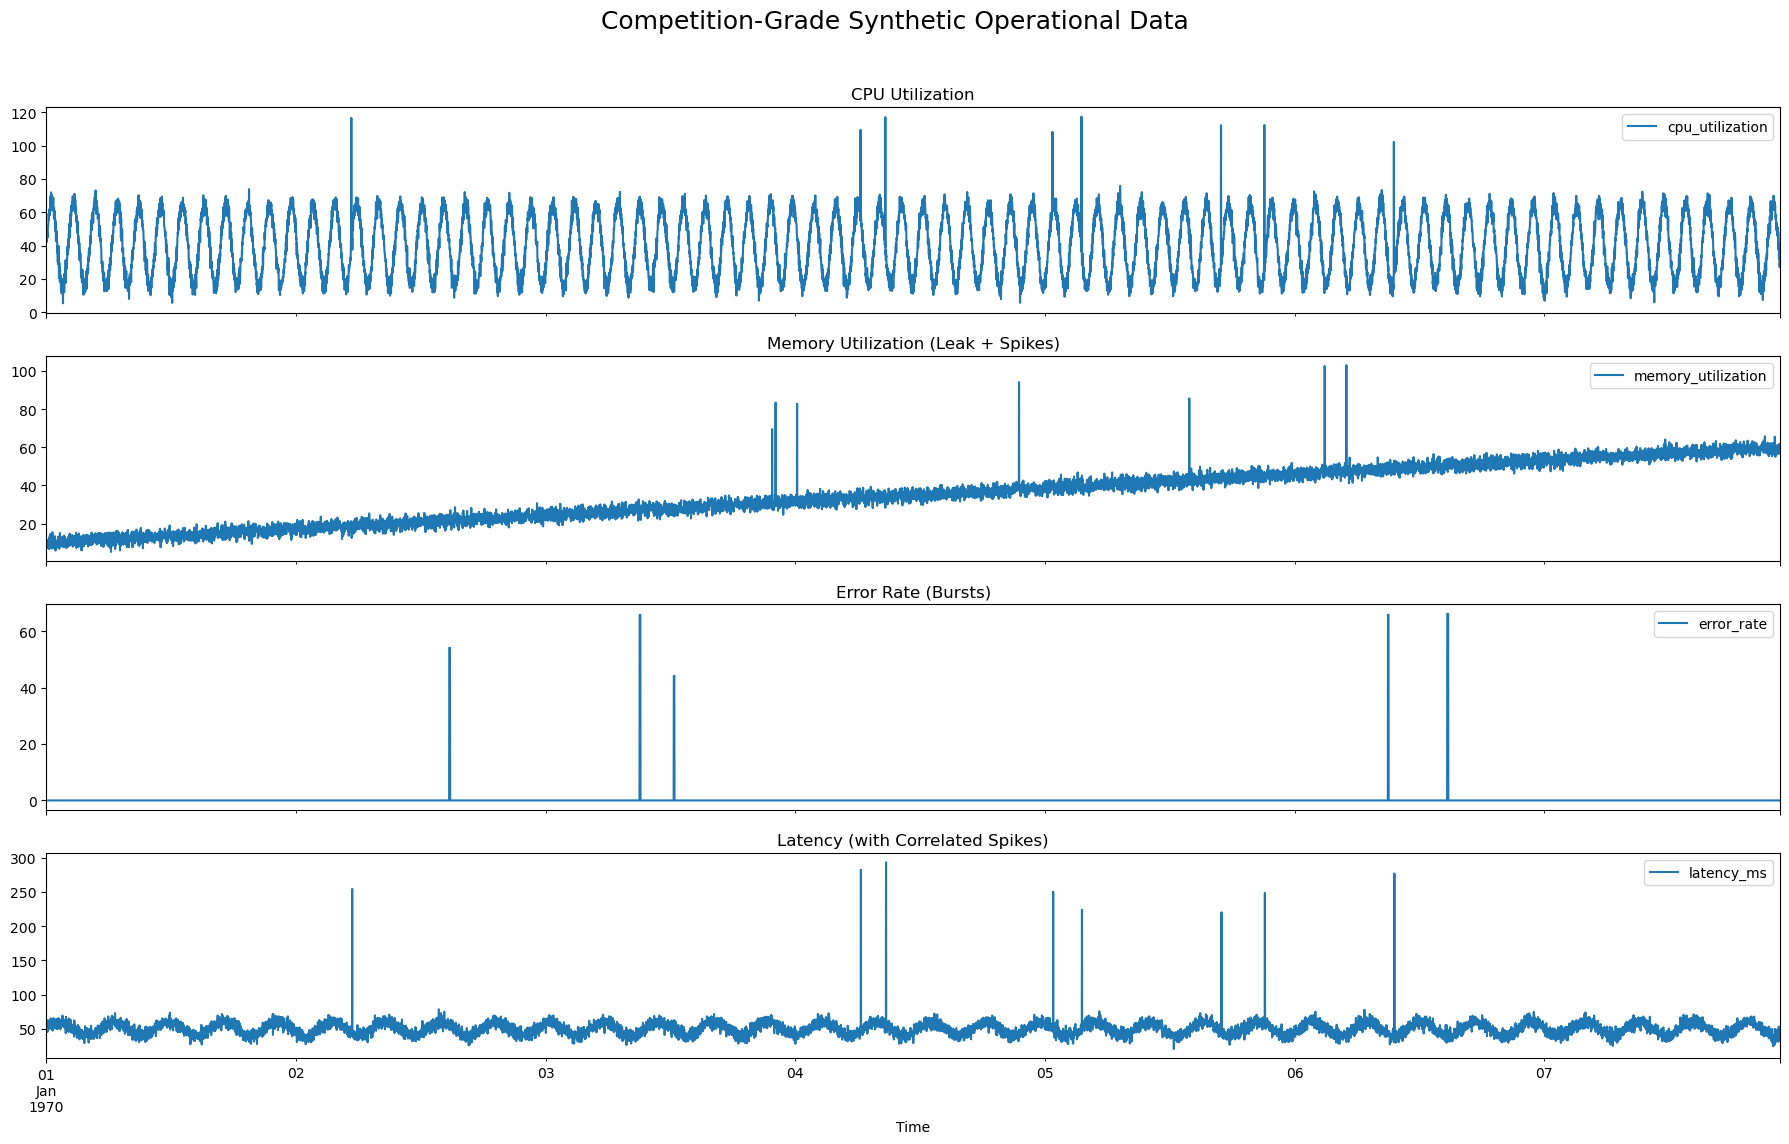

In [53]:
# Create and visualize the new, advanced data
df, ground_truth = generate_advanced_data()

print("Advanced data generated:")
print(df.head())
print("\nSample of Ground Truth Labels:")
print(pd.DataFrame(ground_truth).sample(5))

# Plot the data to see the complex patterns
fig, axes = plt.subplots(4, 1, figsize=(18, 12), sharex=True)
df.plot(x='timestamp', y='cpu_utilization', ax=axes[0], title='CPU Utilization')
df.plot(x='timestamp', y='memory_utilization', ax=axes[1], title='Memory Utilization (Leak + Spikes)')
df.plot(x='timestamp', y='error_rate', ax=axes[2], title='Error Rate (Bursts)')
df.plot(x='timestamp', y='latency_ms', ax=axes[3], title='Latency (with Correlated Spikes)')

fig.suptitle('Competition-Grade Synthetic Operational Data', fontsize=18)
plt.xlabel('Time')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [54]:
# We will continue to train our V1 model only on CPU utilization data.
df_train = df[['cpu_utilization']].copy()

# RCF requires a dummy 'label' column as the first column.
df_train.insert(0, 'dummy_label', 0)

# Save to CSV in a writable directory
home_dir = os.path.expanduser('~') # Gets '/home/sagemaker-user/'
train_csv_path = os.path.join(home_dir, 'train_data.csv')
df_train.to_csv(train_csv_path, header=False, index=False)
print(f"Data with shape {df_train.shape} saved to {train_csv_path}")

# Upload the prepared data to S3
s3_uri = sagemaker_session.upload_data(path=train_csv_path, bucket=bucket, key_prefix=prefix)
print(f"Correctly formatted data uploaded to: {s3_uri}")

Data with shape (10000, 2) saved to /home/sagemaker-user/train_data.csv
Correctly formatted data uploaded to: s3://sagemaker-ap-south-1-712672311489/opsflow-anomaly-detection/train_data.csv


In [55]:
from sagemaker.inputs import TrainingInput

# Retrieve the specific Docker container URI for the RCF algorithm
image_uri = sagemaker.image_uris.retrieve(
    framework="randomcutforest",
    region=region,
    version="1"
)

# Configure the SageMaker Estimator
rcf_estimator = sagemaker.estimator.Estimator(
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=sagemaker_session,
    hyperparameters={
        'num_trees': 100,             # Increased for better accuracy
        'num_samples_per_tree': 512,
        'feature_dim': 1             # Still training on one metric (CPU)
    }
)

# Define the training data source from S3
train_input = TrainingInput(
    s3_data=s3_uri,
    content_type='text/csv',
    distribution='ShardedByS3Key'
)

print("\nStarting model training job... This will take a few minutes.")
rcf_estimator.fit({'train': train_input})
print("\nTraining job completed successfully!")

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: randomcutforest-2025-10-16-07-30-58-314



Starting model training job... This will take a few minutes.
2025-10-16 07:31:01 Starting - Starting the training job...
2025-10-16 07:31:15 Starting - Preparing the instances for training...
2025-10-16 07:31:39 Downloading - Downloading input data...
2025-10-16 07:32:14 Downloading - Downloading the training image...............
2025-10-16 07:34:55 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[10/16/

In [56]:
print(f"Deploying model to permanent endpoint: {endpoint_name}...")
print("This will take several minutes to complete.")

# Deploy the trained estimator to our pre-defined, versioned endpoint name
predictor = rcf_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium', # Use a small, cheap instance for hosting
    endpoint_name=endpoint_name
)

print(f"--- ✅ Endpoint '{endpoint_name}' is now live and ready! ---")

INFO:sagemaker:Creating model with name: randomcutforest-2025-10-16-07-36-40-901


Deploying model to permanent endpoint: opsflow-anomaly-detector-v1...
This will take several minutes to complete.


INFO:sagemaker:Creating endpoint-config with name opsflow-anomaly-detector-v1
INFO:sagemaker:Creating endpoint with name opsflow-anomaly-detector-v1


------------------!--- ✅ Endpoint 'opsflow-anomaly-detector-v1' is now live and ready! ---
